# Predict the Loan Defaulter for Lending Club data using Industry Segmentation and Sentiment Analysis - Removing variables with > 60% correlation (multicolinearity)

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Read the data and perform the necessary pre processing

In [2]:
data_reduced=pd.read_csv("final_data_v3.csv")

## Split X and Y, remove varibales with correlation > 0.6

In [2]:
X=data_reduced.drop(['loan_status'],axis=1)
y=data_reduced[['loan_status']]

In [3]:
correlation_matrix=X.corr()

In [4]:
# Filter the correlation matrix to show only values greater than 0.6
filtered_corr = correlation_matrix.where(correlation_matrix > 0.6, np.nan)

# Set the diagonal values to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns where all elements are NaN
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Melt the DataFrame to show only the non-NaN values
filtered_corr_melted = filtered_corr.stack().reset_index()
filtered_corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']

print(filtered_corr_melted)

              Variable 1            Variable 2  Correlation
0            installment       total_rec_prncp     0.765573
1            delinq_2yrs    num_tl_90g_dpd_24m     0.667981
2                pub_rec  pub_rec_bankruptcies     0.609783
3                pub_rec             tax_liens     0.739624
4              revol_bal      total_rev_hi_lim     0.813389
5              total_acc             num_il_tl     0.695882
6              total_acc         num_rev_accts     0.740337
7              total_acc              num_sats     0.697688
8        total_rec_prncp           installment     0.765573
9        total_rec_prncp       last_pymnt_amnt     0.659399
10       last_pymnt_amnt       total_rec_prncp     0.659399
11  last_fico_range_high   last_fico_range_low     0.841422
12   last_fico_range_low  last_fico_range_high     0.841422
13        acc_now_delinq          num_tl_30dpd     0.820706
14      total_rev_hi_lim             revol_bal     0.813389
15      total_rev_hi_lim        total_bc

In [5]:
col_2_drop=filtered_corr_melted['Variable 2'].unique()

In [6]:
col_2_drop=list(col_2_drop)

In [7]:
X_mod=X.drop(col_2_drop,axis=1)

## With Sentiment and Industry Segmentation

### Train, Test Split With Sentiment Columns

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 114), y_train shape: (116984, 1)
X_test shape: (29247, 114), y_test shape: (29247, 1)


### Implementing Smote for Class imbalance¶

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


In [11]:
import warnings
warnings.filterwarnings("ignore")
models = []
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('KNN', KNeighborsClassifier( )))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('NB',GaussianNB()))
models.append(('XGB', XGBClassifier(random_state=42)))


### Building Machine Learning Model

#### Basic Model

In [12]:
for name, model in models:
    #model_name, _ = model
    model.fit(X_train_smote, y_train_smote)
    y_pred_train = model.predict(X_train_smote)
    y_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy_test}")

LR Train Accuracy: 0.9006153330961301
LR Test Accuracy: 0.9340787089274114
KNN Train Accuracy: 0.8885284329935745
KNN Test Accuracy: 0.690463979211543
CART Train Accuracy: 1.0
CART Test Accuracy: 0.8910999418743802
RF Train Accuracy: 1.0
RF Test Accuracy: 0.9432078503778165
NB Train Accuracy: 0.893064944850248
NB Test Accuracy: 0.8961602899442678
XGB Train Accuracy: 0.9682915088218673
XGB Test Accuracy: 0.9431736588368038


#### Hyper parameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
warnings.filterwarnings("ignore")

# List of models and their hyperparameters to tune
models = []
models.append(('LR', LogisticRegression(random_state=42), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}))
models.append(('KNN', KNeighborsClassifier(), {'n_neighbors': np.arange(5, 35, 5), 'weights': ['uniform', 'distance']}))
models.append(('CART', DecisionTreeClassifier(random_state=42), {'max_depth': np.arange(5, 25, 5), 'min_samples_split': np.arange(5, 25, 5)}))
models.append(('RF', RandomForestClassifier(random_state=42), {'n_estimators': np.arange(5, 25, 5), 'max_features': ['auto', 'sqrt', 'log2']}))
models.append(('NB', GaussianNB(), {}))  # GaussianNB doesn't have hyperparameters to tune
models.append(('XGB', XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}))


# Iterate over each model, perform hyperparameter tuning, and evaluate
for name, model, params in models:
    if params:
        grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # If there are no hyperparameters to tune
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
        best_params = "N/A"
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the best model on the full training data
    best_model.fit(X_train_smote, y_train_smote)
    y_pred = best_model.predict(X_test)
    
    # Calculate classification metrics
    report = classification_report(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC-AUC score if the model supports predict_proba
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = "N/A"
    
    print(f"{name} Classification Report:")
    print(report)
    print(f"Cross-Validation ROC-AUC Score: {mean_cv_score} ± {std_cv_score}")
    print(f"Test ROC-AUC Score: {roc_auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Model Params{best_params}")
    print()
    with open(f'{name}_best_model_WTS_60.pkl', 'wb') as file:
        pickle.dump(best_model, file)

LR Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      5338
           1       0.94      0.98      0.96     23909

    accuracy                           0.94     29247
   macro avg       0.92      0.85      0.88     29247
weighted avg       0.93      0.94      0.93     29247

Cross-Validation ROC-AUC Score: 0.9551534406761902 ± 0.017164531832467366
Test ROC-AUC Score: 0.921732405158494
Confusion Matrix:
[[ 3830  1508]
 [  379 23530]]
Model Params{'C': 100, 'solver': 'lbfgs'}

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.71      0.45      5338
           1       0.91      0.68      0.78     23909

    accuracy                           0.68     29247
   macro avg       0.62      0.69      0.61     29247
weighted avg       0.80      0.68      0.72     29247

Cross-Validation ROC-AUC Score: 0.9596377069762545 ± 0.01019308588037058
Test ROC-AUC Sco

### Build Deep Learning

In [21]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[114]),
keras.layers.Dense(1000, activation="relu"),
keras.layers.Dense(450, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1, activation="sigmoid")
])

In [22]:
train_data = X_train_smote
val_data = X_test
train_labels_mc = y_train_smote
val_labels_mc = y_test

In [23]:
# Since it is binary class classification categorical crossentropy and accuracy as metric is utilized to compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
optimizer=opt,
metrics=["accuracy"])

In [24]:
history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)# Turn verbose=1 to printing epochs

Epoch 1/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8433 - loss: 0.3587 - val_accuracy: 0.9099 - val_loss: 0.2518
Epoch 2/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8848 - loss: 0.2842 - val_accuracy: 0.9103 - val_loss: 0.2540
Epoch 3/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8874 - loss: 0.2787 - val_accuracy: 0.8752 - val_loss: 0.3878
Epoch 4/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8930 - loss: 0.2708 - val_accuracy: 0.9032 - val_loss: 0.2633
Epoch 5/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8884 - loss: 0.2630 - val_accuracy: 0.9287 - val_loss: 0.2365
Epoch 6/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8911 - loss: 0.2621 - val_accuracy: 0.9301 - val_loss: 0.2647
Epoch 7/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8858 - loss: 0.2734 - val_accuracy: 0.9322 - val_loss: 0.2623
Epoch 8/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8739 -

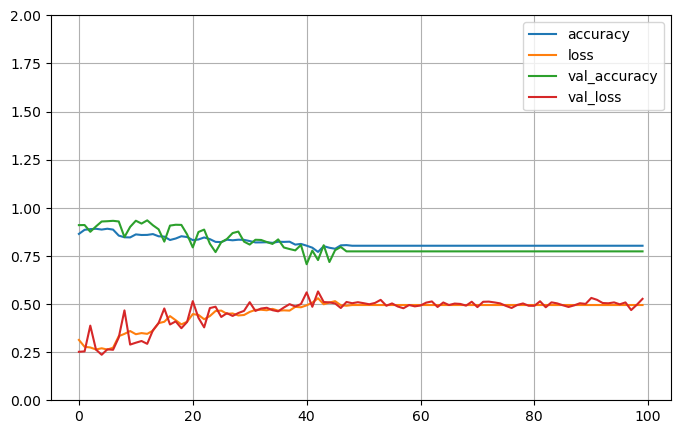

In [25]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import classification_report

# Train your model (already done)
#history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)

# Make predictions on the validation set
predictions = model.predict(val_data)

# Convert predictions to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Generate and print the classification report
report = classification_report(val_labels_mc, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)


914/914 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.44      0.82      0.57      5338
     Class 1       0.95      0.76      0.85     23909

    accuracy                           0.77     29247
   macro avg       0.69      0.79      0.71     29247
weighted avg       0.86      0.77      0.80     29247



## Without Sentiment- Dropping Industry and Sentiment Analysis Column

In [27]:
col2=list(X_mod.filter(regex='Sentiment Score', axis=1).columns)
col2.append(list(X_mod.filter(regex='sector_', axis=1).columns))

In [28]:
col2=['Sentiment Score_2007',
 'Sentiment Score_2008',
 'Sentiment Score_2009',
 'Sentiment Score_2010',
 'Sentiment Score_2011',
 'Sentiment Score_2012',
 'Sentiment Score_2013',
 'Sentiment Score_2014',
 'Sentiment Score_2015',
 'Sentiment Score_2016',
 'Sentiment Score_2017',
 'Sentiment Score_2018','sector_Education',
  'sector_Finance and Banking',
  'sector_Healthcare',
  'sector_IT',
  'sector_Manufacturing']

### Remove Sentiment Columns

In [29]:
X_mod=X_mod.drop(col2,axis=1)

### Train, Test Split

In [30]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 97), y_train shape: (116984, 1)
X_test shape: (29247, 97), y_test shape: (29247, 1)


### Implementing Smote for Class Imbalance

In [31]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


In [32]:
import warnings
warnings.filterwarnings("ignore")
models = []
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('NB',GaussianNB()))
models.append(('XGB', XGBClassifier(random_state=42)))


### Build Machine Learning Model

#### Basic Model

In [33]:
for name, model in models:
    #model_name, _ = model
    model.fit(X_train_smote, y_train_smote)
    y_pred_train = model.predict(X_train_smote)
    y_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy_test}")

LR Train Accuracy: 0.8994694321773163
LR Test Accuracy: 0.9354805621089343
KNN Train Accuracy: 0.902629816446556
KNN Test Accuracy: 0.7149793141176873
CART Train Accuracy: 1.0
CART Test Accuracy: 0.8847061237049954
RF Train Accuracy: 1.0
RF Test Accuracy: 0.942455636475536
NB Train Accuracy: 0.8976433161012161
NB Test Accuracy: 0.9108968441207645
XGB Train Accuracy: 0.9670828188116118
XGB Test Accuracy: 0.943139467295791


#### Hyper Parameter tuning

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
warnings.filterwarnings("ignore")

# List of models and their hyperparameters to tune
models = []
models.append(('LR', LogisticRegression(random_state=42), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}))
models.append(('KNN', KNeighborsClassifier(), {'n_neighbors': np.arange(5, 35, 5), 'weights': ['uniform', 'distance']}))
models.append(('CART', DecisionTreeClassifier(random_state=42), {'max_depth': np.arange(5, 25, 5), 'min_samples_split': np.arange(5, 25, 5)}))
models.append(('RF', RandomForestClassifier(random_state=42), {'n_estimators': np.arange(5, 25, 5), 'max_features': ['auto', 'sqrt', 'log2']}))
models.append(('NB', GaussianNB(), {}))  # GaussianNB doesn't have hyperparameters to tune
models.append(('XGB', XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}))


# Iterate over each model, perform hyperparameter tuning, and evaluate
for name, model, params in models:
    if params:
        grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc')
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # If there are no hyperparameters to tune
        best_model = model
        best_model.fit(X_train_smote, y_train_smote)
        best_params = "N/A"
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the best model on the full training data
    best_model.fit(X_train_smote, y_train_smote)
    y_pred = best_model.predict(X_test)
    
    # Calculate classification metrics
    report = classification_report(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC-AUC score if the model supports predict_proba
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = "N/A"
    
    print(f"{name} Classification Report:")
    print(report)
    print(f"Cross-Validation ROC-AUC Score: {mean_cv_score} ± {std_cv_score}")
    print(f"Test ROC-AUC Score: {roc_auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Model Params{best_params}")
    print()
    with open(f'{name}_best_model_WS_60.pkl', 'wb') as file:
        pickle.dump(best_model, file)

LR Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      5338
           1       0.94      0.99      0.96     23909

    accuracy                           0.94     29247
   macro avg       0.93      0.85      0.88     29247
weighted avg       0.94      0.94      0.93     29247

Cross-Validation ROC-AUC Score: 0.9498457436256658 ± 0.017695987890047612
Test ROC-AUC Score: 0.9143995245115814
Confusion Matrix:
[[ 3784  1554]
 [  301 23608]]
Model Params{'C': 100, 'solver': 'lbfgs'}

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.67      0.46      5338
           1       0.91      0.72      0.80     23909

    accuracy                           0.71     29247
   macro avg       0.63      0.69      0.63     29247
weighted avg       0.81      0.71      0.74     29247

Cross-Validation ROC-AUC Score: 0.9594500003621974 ± 0.007488783313168847
Test ROC-AUC S

### Deep Learning

In [36]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[97]),
keras.layers.Dense(1000, activation="relu"),
keras.layers.Dense(450, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1, activation="sigmoid")
])

In [37]:
train_data = X_train_smote
val_data = X_test

In [38]:
train_labels_mc = y_train_smote
val_labels_mc = y_test

In [39]:
# Since it is binary class classification categorical crossentropy and accuracy as metric is utilized to compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="binary_crossentropy",
optimizer=opt,
metrics=["accuracy"])

In [40]:
history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)# Turn verbose=1 to printing epochs

Epoch 1/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.8396 - loss: 0.3673 - val_accuracy: 0.8735 - val_loss: 0.3317
Epoch 2/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8727 - loss: 0.3005 - val_accuracy: 0.9252 - val_loss: 0.2330
Epoch 3/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8636 - loss: 0.3232 - val_accuracy: 0.9263 - val_loss: 0.3405
Epoch 4/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8221 - loss: 0.4017 - val_accuracy: 0.9233 - val_loss: 0.3650
Epoch 5/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8182 - loss: 0.4103 - val_accuracy: 0.9310 - val_loss: 0.3196
Epoch 6/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8268 - loss: 0.3950 - val_accuracy: 0.9258 - val_loss: 0.3517
Epoch 7/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8113 - loss: 0.4192 - val_accuracy: 0.9184 - val_loss: 0.4060
Epoch 8/100
5973/5973 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8066 -

In [41]:
import numpy as np
from sklearn.metrics import classification_report

# Train your model (already done)
#history = model.fit(train_data, train_labels_mc, epochs=100, validation_data=(val_data, val_labels_mc), verbose=1)

# Make predictions on the validation set
predictions = model.predict(val_data)

# Convert predictions to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Generate and print the classification report
report = classification_report(val_labels_mc, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)


914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

     Class 0       1.00      0.64      0.78      5338
     Class 1       0.93      1.00      0.96     23909

    accuracy                           0.93     29247
   macro avg       0.96      0.82      0.87     29247
weighted avg       0.94      0.93      0.93     29247



## Statistical Test 

In [1]:
import pandas as pd
import numpy as np
data_reduced=pd.read_csv("final_data_v3.csv")
X=data_reduced.drop(['loan_status'],axis=1)
y=data_reduced[['loan_status']]

In [2]:
correlation_matrix=X.corr()

In [3]:
# Filter the correlation matrix to show only values greater than 0.6
filtered_corr = correlation_matrix.where(correlation_matrix > 0.6, np.nan)

# Set the diagonal values to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns where all elements are NaN
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Melt the DataFrame to show only the non-NaN values
filtered_corr_melted = filtered_corr.stack().reset_index()
filtered_corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']

print(filtered_corr_melted)

              Variable 1            Variable 2  Correlation
0            installment       total_rec_prncp     0.765573
1            delinq_2yrs    num_tl_90g_dpd_24m     0.667981
2                pub_rec  pub_rec_bankruptcies     0.609783
3                pub_rec             tax_liens     0.739624
4              revol_bal      total_rev_hi_lim     0.813389
5              total_acc             num_il_tl     0.695882
6              total_acc         num_rev_accts     0.740337
7              total_acc              num_sats     0.697688
8        total_rec_prncp           installment     0.765573
9        total_rec_prncp       last_pymnt_amnt     0.659399
10       last_pymnt_amnt       total_rec_prncp     0.659399
11  last_fico_range_high   last_fico_range_low     0.841422
12   last_fico_range_low  last_fico_range_high     0.841422
13        acc_now_delinq          num_tl_30dpd     0.820706
14      total_rev_hi_lim             revol_bal     0.813389
15      total_rev_hi_lim        total_bc

In [4]:
col_2_drop=filtered_corr_melted['Variable 2'].unique()
col_2_drop=list(col_2_drop)
X_mod=X.drop(col_2_drop,axis=1)

### With Sentiment - Final XGB model with the best parameters and feature importance

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (116984, 114), y_train shape: (116984, 1)
X_test shape: (29247, 114), y_test shape: (29247, 1)


In [6]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_smote)}")

SMOTE target distribution: Counter({'loan_status': 1})


Test Accuracy: 0.94300270113174
Test Precision: 0.935741713031894
Test Recall: 0.9988707181396127
Test F1 Score: 0.9662762234225486
Test ROC AUC: 0.9301049230925408

Feature Importance:
                     Feature  Importance
7    collection_recovery_fee    0.812518
107   debt_settlement_flag_N    0.029616
0                   int_rate    0.011298
36                   grade_A    0.009286
6         total_rec_late_fee    0.007299
34            term_36 months    0.006229
30      Sentiment Score_2015    0.004997
29      Sentiment Score_2014    0.004778
100    initial_list_status_f    0.003797
82       home_ownership_RENT    0.003738
33      Sentiment Score_2018    0.003303
31      Sentiment Score_2016    0.002744
38                   grade_C    0.002625
32      Sentiment Score_2017    0.002408
28      Sentiment Score_2013    0.002254
16                  mort_acc    0.002135
97    purpose_small_business    0.001966
1                 annual_inc    0.001936
2                        dti    0.0

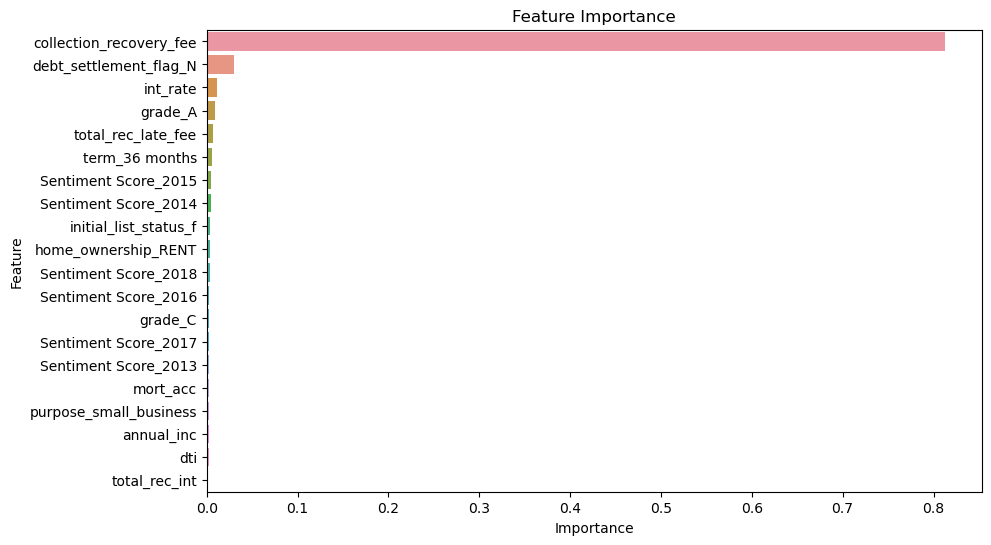

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model with specified parameters
model_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
model = XGBClassifier(**model_params)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on both the training and test data
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

# Calculate probabilities for ROC AUC
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics for the training data
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Calculate metrics for the test data
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

'''
# Print the metrics
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")
'''

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test ROC AUC: {roc_auc_test}")

# Get feature importance
feature_importances = model.feature_importances_
features = X_mod.columns 
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:20]

# Print feature importance
print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


### Without Sentiment - Final XGB model with the best parameters and feature importance

In [8]:
col2=['Sentiment Score_2007',
 'Sentiment Score_2008',
 'Sentiment Score_2009',
 'Sentiment Score_2010',
 'Sentiment Score_2011',
 'Sentiment Score_2012',
 'Sentiment Score_2013',
 'Sentiment Score_2014',
 'Sentiment Score_2015',
 'Sentiment Score_2016',
 'Sentiment Score_2017',
 'Sentiment Score_2018','sector_Education',
  'sector_Finance and Banking',
  'sector_Healthcare',
  'sector_IT',
  'sector_Manufacturing']

In [9]:
X_mod_no_senti=X_mod.drop(col2,axis=1)

# Split the data into train and test sets
X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_no_senti = scaler.fit_transform(X_train_no_senti)
X_test_no_senti = scaler.transform(X_test_no_senti)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train_no_senti.shape}, y_train shape: {y_train_no_senti.shape}")
print(f"X_test shape: {X_test_no_senti.shape}, y_test shape: {y_test_no_senti.shape}")

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_no_senti, y_train_no_senti = smote.fit_resample(X_train_no_senti, y_train_no_senti)

# Check the distribution of the target after SMOTE
print(f"SMOTE target distribution: {Counter(y_train_no_senti)}")

X_train shape: (116984, 97), y_train shape: (116984, 1)
X_test shape: (29247, 97), y_test shape: (29247, 1)
SMOTE target distribution: Counter({'loan_status': 1})


Test Accuracy: 0.9430710842137655
Test Precision: 0.9357808949141917
Test Recall: 0.9989125433937012
Test F1 Score: 0.9663166838623536
Test ROC AUC: 0.9182714633249173

Feature Importance:
                                Feature  Importance
7               collection_recovery_fee    0.822878
23                       term_60 months    0.042549
4                        inq_last_6mths    0.013579
89                initial_list_status_w    0.010603
16                             mort_acc    0.010257
19                num_accts_ever_120_pd    0.007945
71     verification_status_Not Verified    0.007563
22                       term_36 months    0.006796
70                  home_ownership_RENT    0.005850
95               debt_settlement_flag_N    0.005629
6                    total_rec_late_fee    0.004988
77           purpose_debt_consolidation    0.004386
72  verification_status_Source Verified    0.003284
15                       mo_sin_rcnt_tl    0.003031
0                              

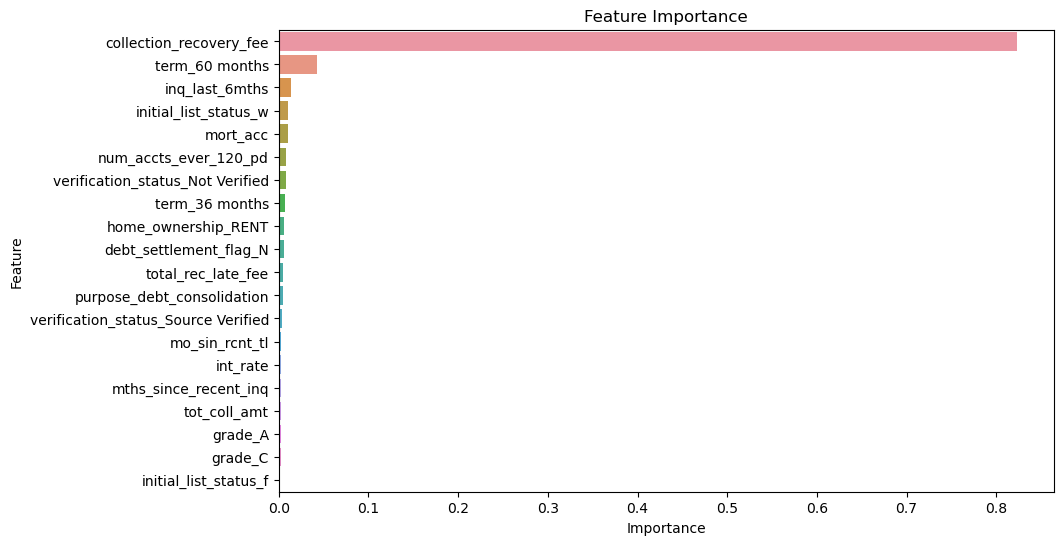

In [10]:

# Initialize the model with specified parameters
model_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
model1 = XGBClassifier(**model_params)

# Fit the model on the training data
model1.fit(X_train_no_senti, y_train_no_senti)

# Make predictions on both the training and test data
y_pred_train = model1.predict(X_train_no_senti)
y_pred = model1.predict(X_test_no_senti)

# Calculate probabilities for ROC AUC
y_pred_proba_train = model1.predict_proba(X_train_no_senti)[:, 1]
y_pred_proba = model1.predict_proba(X_test_no_senti)[:, 1]

# Calculate metrics for the training data
accuracy_train = accuracy_score(y_train_no_senti, y_pred_train)
precision_train = precision_score(y_train_no_senti, y_pred_train)
recall_train = recall_score(y_train_no_senti, y_pred_train)
f1_train = f1_score(y_train_no_senti, y_pred_train)
roc_auc_train = roc_auc_score(y_train_no_senti, y_pred_proba_train)

# Calculate metrics for the test data
accuracy_test = accuracy_score(y_test_no_senti, y_pred)
precision_test = precision_score(y_test_no_senti, y_pred)
recall_test = recall_score(y_test_no_senti, y_pred)
f1_test = f1_score(y_test_no_senti, y_pred)
roc_auc_test = roc_auc_score(y_test_no_senti, y_pred_proba)

# Print the metrics
'''
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")
'''
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test ROC AUC: {roc_auc_test}")

# Get feature importance
feature_importances = model1.feature_importances_
features = X_mod_no_senti.columns 
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:20]

# Print feature importance
print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


### Perform t-test (Statistical test for the best models of with and without sentiment, for accuracy and ROC AUC scores)

In [11]:
from scipy.stats import ttest_rel
# Initialize models
model_params1 = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
model_params2 = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
model1 = XGBClassifier(**model_params1)
model2 = XGBClassifier(**model_params2)
# Store accuracies
accuracies_model1 = []
accuracies_model2 = []

# Number of runs
n_runs = 31

for i in range(n_runs):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=i)
    
    # Model 1
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    acc1 = accuracy_score(y_test, y_pred1)
    accuracies_model1.append(acc1)
    
    X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state= i)
    # Model 2
    model2.fit(X_train_no_senti, y_train_no_senti)
    y_pred2 = model2.predict(X_test_no_senti)
    acc2 = accuracy_score(y_test_no_senti, y_pred2)
    accuracies_model2.append(acc2)

# Perform paired t-test
t_stat, p_value = ttest_rel(accuracies_model1, accuracies_model2)

print(f"Model 1 Accuracies: {accuracies_model1}")
print(f"Model 2 Accuracies: {accuracies_model2}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in accuracies is statistically significant.")
else:
    print("The difference in accuracies is not statistically significant.")


Model 1 Accuracies: [0.9434813827059185, 0.9430710842137655, 0.9442335966081992, 0.9435155742469313, 0.9447122781823777, 0.943823298116046, 0.9417718056552808, 0.9416350394912298, 0.9434813827059185, 0.9433446165418675, 0.9452935343795945, 0.9469347283482067, 0.945772215953773, 0.9467295791021302, 0.9443703627722502, 0.943276233459842, 0.9447464697233904, 0.946045748281875, 0.9450200020514925, 0.9420795295243957, 0.9443703627722502, 0.9429685095907272, 0.9465244298560536, 0.9438574896570588, 0.9438574896570588, 0.9430710842137655, 0.9439258727390843, 0.9446097035593394, 0.9439942558211099, 0.943686531951995, 0.9441310219851609]
Model 2 Accuracies: [0.9431052757547783, 0.942865934967689, 0.9437549150340205, 0.9430368926727528, 0.9438916811980717, 0.9437549150340205, 0.9418401887373063, 0.9413273156221151, 0.943412999623893, 0.9430710842137655, 0.9451225766745307, 0.9463534721509899, 0.94536191746162, 0.946319280609977, 0.9438916811980717, 0.9432078503778165, 0.9444387458542757, 0.945840

In [12]:

# Store accuracies
roc_model1 = []
roc_model2 = []

# Number of runs
n_runs = 31

for i in range(n_runs):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size=0.2, random_state=i)
    
    # Model 1
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    # Calculate probabilities for ROC AUC
    y_pred_proba_train1 = model1.predict_proba(X_train)[:, 1]
    y_pred_proba1 = model1.predict_proba(X_test)[:, 1]
    roc1=roc_auc_score(y_test, y_pred_proba1)
    roc_model1.append(roc1)
    
    X_train_no_senti, X_test_no_senti, y_train_no_senti, y_test_no_senti = train_test_split(X_mod_no_senti, y, test_size=0.2, random_state= i)
    # Model 2
    model2.fit(X_train_no_senti, y_train_no_senti)
    y_pred2 = model2.predict(X_test_no_senti)
    #Calculate probabilities for ROC AUC
    y_pred_proba_train2 = model2.predict_proba(X_train_no_senti)[:, 1]
    y_pred_proba2 = model2.predict_proba(X_test_no_senti)[:, 1]
    roc2=roc_auc_score(y_test_no_senti, y_pred_proba2)
    roc_model2.append(roc2)
    

# Perform paired t-test
t_stat, p_value = ttest_rel(roc_model1, roc_model2)

print(f"Model 1 Accuracies: {roc_model1}")
print(f"Model 2 Accuracies: {roc_model2}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The difference in roc is statistically significant.")
else:
    print("The difference in roc is not statistically significant.")


Model 1 Accuracies: [0.930397615478047, 0.9282228516660547, 0.9325374300968583, 0.9296623730408046, 0.929856310294447, 0.9303421927750803, 0.9304317068335718, 0.9305208227724929, 0.9282938085853187, 0.9257001387547065, 0.933531026062729, 0.9351786424192897, 0.9322717004710028, 0.9373516461703819, 0.9308878050034797, 0.9280996981307029, 0.9292766795605812, 0.9353766371640705, 0.9312279402819349, 0.931122473899839, 0.9329327849140906, 0.9333156184969408, 0.9302559831872622, 0.9298828931466926, 0.9266857563815508, 0.9284670758996472, 0.9298262531977031, 0.9310294074469695, 0.9309947901886138, 0.9309984273310284, 0.9302945512439647]
Model 2 Accuracies: [0.9205823847134194, 0.917136017771848, 0.922221778775258, 0.9182920586191043, 0.920696489740034, 0.9192962367434314, 0.9195410219244655, 0.9192205157846448, 0.9174914838574997, 0.9172929353778004, 0.9245363930867784, 0.925792538348859, 0.922932872346116, 0.9269755229339695, 0.9211291540703006, 0.9171085284308568, 0.917340341575462, 0.925505

## Conclusion


From the result, we can conclude that there is difference/ increase in accuracy when adding sentiment columns for the removing 60% collinearity dataset.